# Pre-Processing & Modelling

We are here! We are finally here! I'm ready to build a model to predict SPI scores based on transfer spending data, after some pre-processing.

__What's Happened So Far:__
 - Found data to use. View it here.
 - Cleaned the transfers data. Notebook
 - Cleaned the SPI data. Notebook
 - Learned how to create new features!
 - Visualized the new features and looked at correlations. Notebook

Now, the moment of truth. 

As always, first steps are reading in the data and import libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
path = '/home/tdraths/sb_assignments/Transfers_Capstone/data/data_cleaning_outputs/SPI_Transfers_Features.csv'
df = pd.read_csv(path, index_col=0)
pd.set_option('display.max_columns', None)
display(df.shape)
df.sample(5)

(100, 26)

,Year,Team,Team Name,Total Transfers (In),Total Transfers (Out),Total Spent (In),Total Earned (Out),Average Fee (In),Max Fee Spent,Min Fee Spent,Average Home SPI Score,Average Away SPI Score,Average Season SPI Score,Most Purchased Position,Position Max Spend,Position Min Spend,Average Spent on Goalkeeper,Average Spent on Left-Back,Average Spent on Right-Back,Average Spent on Centre-Back,Average Spent on Defensive Midfielder,Average Spent on Left Winger,Average Spent on Attacking Midfielder,Average Spent on Right Winger,Average Spent on Striker,spi_diffs
60,2019,ARS,Arsenal,15,20,144360000.0,47160000.0,9.624000e+06,72000000.0,27360000.0,77.786842,77.393684,77.59,Centre-Back,Right Winger,Left Winger,0.0,24300000.0,0.0,14010000.0,0.0,2.010000e+06,0.0,36000000.0,0.000000e+00,-3.02
57,2018,WAT,Watford,23,23,27100000.0,46656000.0,1.178261e+06,11700000.0,35280000.0,69.451053,69.436316,69.44,Striker,Left Winger,Defensive Midfielder,840000.0,4500000.0,900000.0,382500.0,0.0,6.766667e+05,990000.0,11700000.0,3.383333e+05,10.88
79,2019,WLV,Wolverhampton,26,25,108180000.0,21690000.0,4.160769e+06,34200000.0,10620000.0,77.158947,77.000000,77.08,Striker,Striker,Striker,0.0,0.0,0.0,0.0,12420000.0,1.125000e+07,2002500.0,0.0,6.000000e+06,8.48
64,2019,BUR,Burnley,8,10,16480000.0,12200000.0,2.060000e+06,9000000.0,7920000.0,69.716316,69.722632,69.72,Striker,Attacking Midfielder,Striker,2480000.0,0.0,0.0,0.0,0.0,0.000000e+00,3000000.0,0.0,1.666667e+06,8.48
68,2019,LEI,Leicester City,11,12,93870000.0,79650000.0,8.533636e+06,40500000.0,78300000.0,80.730000,80.597368,80.66,Attacking Midfielder,Centre-Back,Attacking Midfielder,0.0,0.0,6030000.0,0.0,0.0,0.000000e+00,11556000.0,0.0,1.503000e+07,9.12


## Dummies for Days
Some of my new features are categorical, and describe the positions a team bought the most of, spent the most on and spent the least on, respectively. You can see these in `Most Purchased Position`, `Position Max Spend`, `Position Min Spend`.

Below, I define those columns in a list and then create a dataframe with my current `df` and the new dummy features. I'm surprised by how easy this is.

In [3]:
columns = ['Most Purchased Position', 'Position Max Spend', 'Position Min Spend']
df_dummies = pd.get_dummies(df, columns=columns)
display(df_dummies.shape)
df_dummies.sample()

(100, 50)

,Year,Team,Team Name,Total Transfers (In),Total Transfers (Out),Total Spent (In),Total Earned (Out),Average Fee (In),Max Fee Spent,Min Fee Spent,Average Home SPI Score,Average Away SPI Score,Average Season SPI Score,Average Spent on Goalkeeper,Average Spent on Left-Back,Average Spent on Right-Back,Average Spent on Centre-Back,Average Spent on Defensive Midfielder,Average Spent on Left Winger,Average Spent on Attacking Midfielder,Average Spent on Right Winger,Average Spent on Striker,spi_diffs,Most Purchased Position_Attacking Midfielder,Most Purchased Position_Centre-Back,Most Purchased Position_Defensive Midfielder,Most Purchased Position_Goalkeeper,Most Purchased Position_Left Winger,Most Purchased Position_Left-Back,Most Purchased Position_Right Winger,Most Purchased Position_Right-Back,Most Purchased Position_Striker,Position Max Spend_Attacking Midfielder,Position Max Spend_Centre-Back,Position Max Spend_Defensive Midfielder,Position Max Spend_Goalkeeper,Position Max Spend_Left Winger,Position Max Spend_Left-Back,Position Max Spend_Right Winger,Position Max Spend_Right-Back,Position Max Spend_Striker,Position Min Spend_Attacking Midfielder,Position Min Spend_Centre-Back,Position Min Spend_Defensive Midfielder,Position Min Spend_Goalkeeper,Position Min Spend_Left Winger,Position Min Spend_Left-Back,Position Min Spend_Right Winger,Position Min Spend_Right-Back,Position Min Spend_Striker
7,2016,LEI,Leicester City,17,18,82440000.0,59450000.0,4.849412e+06,27450000.0,32220000.0,62.715789,62.918947,62.82,3150000.0,0.0,0.0,0.0,14895000.0,0.0,1500000.0,0.0,11250000.0,4.1925,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## II. Trying Different Scalers
I'm new to this, and I'm not sure whether MinMax, StandardScaler or another method is best for my data. In this section, I'm going to attempt each and see which seems to make the most sense.

In [4]:
df_dummies.drop(columns=['Year', 'Team', 'Team Name'], inplace=True)

In [5]:
end = df_dummies['Average Season SPI Score']
df_dummies.drop(labels=['Average Season SPI Score'], axis=1, inplace=True)
df_dummies.insert(0, 'Average Season SPI Score', end)
df_dummies

,Average Season SPI Score,Total Transfers (In),Total Transfers (Out),Total Spent (In),Total Earned (Out),Average Fee (In),Max Fee Spent,Min Fee Spent,Average Home SPI Score,Average Away SPI Score,Average Spent on Goalkeeper,Average Spent on Left-Back,Average Spent on Right-Back,Average Spent on Centre-Back,Average Spent on Defensive Midfielder,Average Spent on Left Winger,Average Spent on Attacking Midfielder,Average Spent on Right Winger,Average Spent on Striker,spi_diffs,Most Purchased Position_Attacking Midfielder,Most Purchased Position_Centre-Back,Most Purchased Position_Defensive Midfielder,Most Purchased Position_Goalkeeper,Most Purchased Position_Left Winger,Most Purchased Position_Left-Back,Most Purchased Position_Right Winger,Most Purchased Position_Right-Back,Most Purchased Position_Striker,Position Max Spend_Attacking Midfielder,Position Max Spend_Centre-Back,Position Max Spend_Defensive Midfielder,Position Max Spend_Goalkeeper,Position Max Spend_Left Winger,Position Max Spend_Left-Back,Position Max Spend_Right Winger,Position Max Spend_Right-Back,Position Max Spend_Striker,Position Min Spend_Attacking Midfielder,Position Min Spend_Centre-Back,Position Min Spend_Defensive Midfielder,Position Min Spend_Goalkeeper,Position Min Spend_Left Winger,Position Min Spend_Left-Back,Position Min Spend_Right Winger,Position Min Spend_Right-Back,Position Min Spend_Striker
0,81.98,12,12,101736000.0,9320000.0,8.478000e+06,40500000.0,4500000.0,82.174211,81.785789,0.0,36000.0,0.0,9900000.0,40500000.0,0.0,0.0,0.0,7200000.0,-0.797500,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,60.88,19,26,36626000.0,22941000.0,1.927684e+06,16200000.0,10800000.0,60.945789,60.804211,846000.0,1620000.0,0.0,517500.0,0.0,0.0,2105000.0,4050000.0,1950000.0,1.906667,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,57.72,26,25,41040000.0,1080000.0,1.578462e+06,13590000.0,1080000.0,57.487368,57.947895,1170000.0,0.0,0.0,0.0,5220000.0,6795000.0,2295000.0,2700000.0,0.0,2.875000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,84.54,27,30,119520000.0,97560000.0,4.426667e+06,35100000.0,54000000.0,84.546842,84.528421,0.0,10350000.0,0.0,6300000.0,0.0,0.0,6444000.0,0.0,8775000.0,-0.080000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,58.51,22,25,91170000.0,45180000.0,4.144091e+06,28080000.0,26010000.0,58.646842,58.364737,0.0,9450000.0,0.0,4200000.0,3397500.0,2484000.0,0.0,14040000.0,5814000.0,2.775000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,71.02,16,13,36270000.0,23670000.0,2.266875e+06,13500000.0,14940000.0,71.012632,71.021053,0.0,0.0,5985000.0,3600000.0,3375000.0,0.0,0.0,0.0,0.0,1.560000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
96,78.54,11,7,88560000.0,11970000.0,8.050909e+06,28800000.0,11970000.0,78.557368,78.525789,0.0,13500000.0,7560000.0,0.0,7470000.0,0.0,28800000.0,0.0,2700000.0,-2.330000,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
97,58.38,10,12,22320000.0,6840000.0,2.232000e+06,12150000.0,5850000.0,58.420526,58.345263,495000.0,0.0,0.0,495000.0,0.0,6075000.0,0.0,4095000.0,0.0,4.250000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
98,69.04,9,10,19980000.0,20520000.0,2.220000e+06,14580000.0,12150000.0,69.082105,68.997368,0.0,0.0,2700000.0,0.0,14580000.0,0.0,0.0,0.0,0.0,1.740000,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [6]:
col_names = list(df_dummies.columns)

<AxesSubplot:title={'center':'Original Distributions'}>

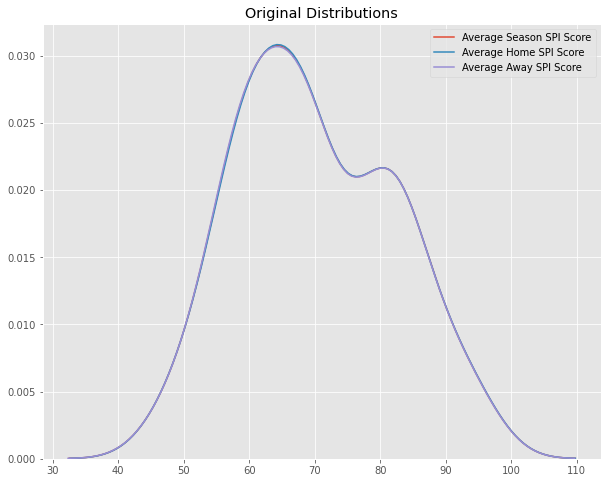

In [7]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

sns.kdeplot(df_dummies['Average Season SPI Score'], ax=ax1)
sns.kdeplot(df_dummies['Average Home SPI Score'], ax=ax1)
sns.kdeplot(df_dummies['Average Away SPI Score'], ax=ax1)

<AxesSubplot:title={'center':'Original Distributions'}>

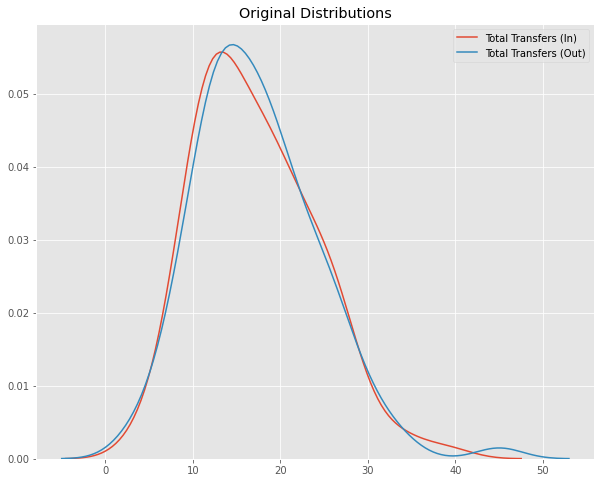

In [8]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

sns.kdeplot(df_dummies['Total Transfers (In)'], ax=ax1)
sns.kdeplot(df_dummies['Total Transfers (Out)'], ax=ax1)

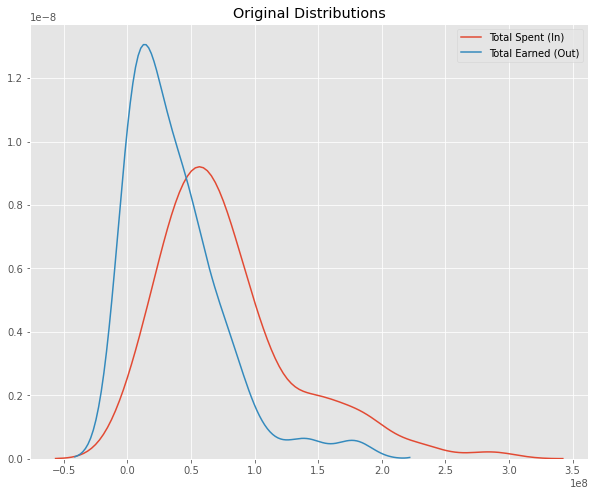

In [9]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

sns.kdeplot(df_dummies['Total Spent (In)'], ax=ax1)
sns.kdeplot(df_dummies['Total Earned (Out)'], ax=ax1);

In [10]:
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(df_dummies)

df_mm = pd.DataFrame(df_mm, columns=col_names)

In [11]:
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(df_dummies)
df_r = pd.DataFrame(df_r, columns=col_names)

In [12]:
s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df_dummies)

df_s = pd.DataFrame(df_s, columns=col_names)

In [13]:
# n_scaler = preprocessing.Normalizer()
# df_n = n_scaler.fit_transform(df_dummies)

# df_n = pd.DataFrame(df_n, columns=col_names)

# fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))
# ax1.set_title('After Normalizer')

# sns.kdeplot(df_n['Average Season SPI Score'], ax=ax1)
# sns.kdeplot(df_n['Average Home SPI Score'], ax=ax1)
# sns.kdeplot(df_n['Average Away SPI Score'], ax=ax1)
# sns.kdeplot(df_n['Total Transfers (In)'], ax=ax1)
# sns.kdeplot(df_n['Total Transfers (Out)'], ax=ax1)
# sns.kdeplot(df_n['Total Spent (In)'], ax=ax1)
# sns.kdeplot(df_n['Total Earned (Out)'], ax=ax1);

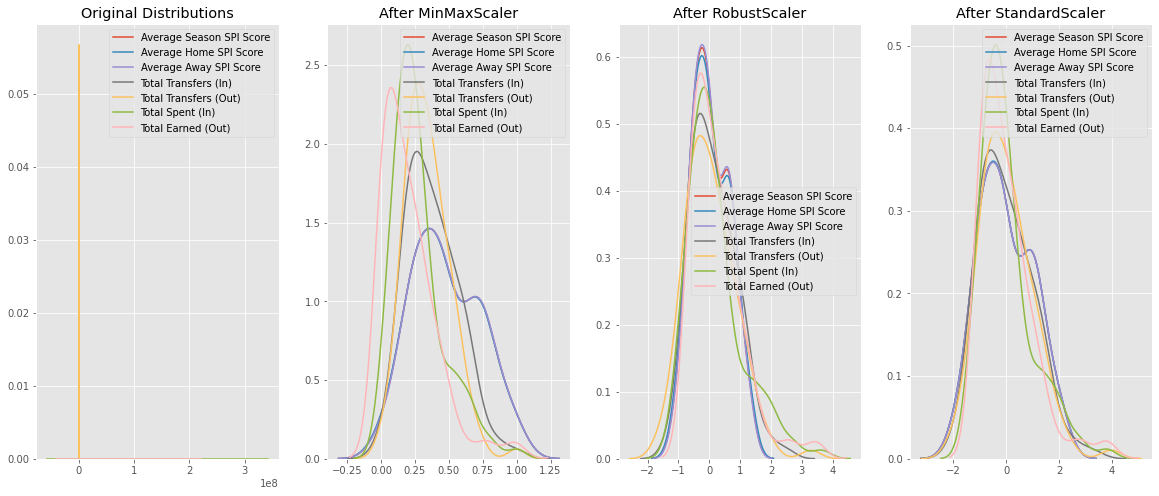

In [14]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20,8))

ax0.set_title('Original Distributions')
sns.kdeplot(df_dummies['Average Season SPI Score'], ax=ax0)
sns.kdeplot(df_dummies['Average Home SPI Score'], ax=ax0)
sns.kdeplot(df_dummies['Average Away SPI Score'], ax=ax0)
sns.kdeplot(df_dummies['Total Transfers (In)'], ax=ax0)
sns.kdeplot(df_dummies['Total Transfers (Out)'], ax=ax0)
sns.kdeplot(df_dummies['Total Spent (In)'], ax=ax0)
sns.kdeplot(df_dummies['Total Earned (Out)'], ax=ax0);


ax1.set_title('After MinMaxScaler')
sns.kdeplot(df_mm['Average Season SPI Score'], ax=ax1)
sns.kdeplot(df_mm['Average Home SPI Score'], ax=ax1)
sns.kdeplot(df_mm['Average Away SPI Score'], ax=ax1)
sns.kdeplot(df_mm['Total Transfers (In)'], ax=ax1)
sns.kdeplot(df_mm['Total Transfers (Out)'], ax=ax1)
sns.kdeplot(df_mm['Total Spent (In)'], ax=ax1)
sns.kdeplot(df_mm['Total Earned (Out)'], ax=ax1);


ax2.set_title('After RobustScaler')
sns.kdeplot(df_r['Average Season SPI Score'], ax=ax2)
sns.kdeplot(df_r['Average Home SPI Score'], ax=ax2)
sns.kdeplot(df_r['Average Away SPI Score'], ax=ax2)
sns.kdeplot(df_r['Total Transfers (In)'], ax=ax2)
sns.kdeplot(df_r['Total Transfers (Out)'], ax=ax2)
sns.kdeplot(df_r['Total Spent (In)'], ax=ax2)
sns.kdeplot(df_r['Total Earned (Out)'], ax=ax2);


ax3.set_title('After StandardScaler')
sns.kdeplot(df_s['Average Season SPI Score'], ax=ax3)
sns.kdeplot(df_s['Average Home SPI Score'], ax=ax3)
sns.kdeplot(df_s['Average Away SPI Score'], ax=ax3)
sns.kdeplot(df_s['Total Transfers (In)'], ax=ax3)
sns.kdeplot(df_s['Total Transfers (Out)'], ax=ax3)
sns.kdeplot(df_s['Total Spent (In)'], ax=ax3)
sns.kdeplot(df_s['Total Earned (Out)'], ax=ax3);


In [15]:
#X = df_dummies.drop(columns=['Average Season SPI Score'])
#y = df_dummies['Average Season SPI Score']